# Обучение модели классификации комментариев BERT

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Требуется инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

In [187]:
#!pip install torch
#!pip install transformers
#!pip install pymystem3

In [188]:
import numpy as np
import pandas as pd
import nltk
import re

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline

from lightgbm import LGBMClassifier

from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer

## Подготовка

### Импорт данных

In [197]:
df = pd.read_csv('/datasets/toxic_comments.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


### EDA

<AxesSubplot:>

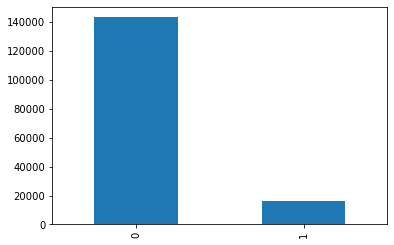

In [79]:
df['toxic'].value_counts().plot(kind='bar')

- Пропусков в данных нет
- Наблюдается сильный дисбаланс в целевом признаке

### Очистка и лемматизация

In [198]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):    
    text = text.lower()
    words = text.split(" ")
    lemm_text = "".join([lemmatizer.lemmatize(w) for w in words])
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

df['text'] = df['text'].apply(lemmatize_text)

### Разбивка данных для обучения

In [199]:
target = df['toxic']
features = df.drop(['toxic'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.2, 
                                                                              random_state=12345)
print(features_train.shape)
print(features_test.shape)

(127656, 1)
(31915, 1)


## Выбор модели

Задача относится к классу задач классификации. Опробуем несколько моделей. В качестве критерия качества выбираем F1

In [84]:
# Подготовка стоп-слов
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alogv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Логистическая регрессия

In [48]:
clf = Pipeline([('vect', TfidfVectorizer(stop_words=stopwords)), ('logr',  LogisticRegression(random_state=12345, class_weight='balanced'))])
cv = RepeatedStratifiedKFold(n_splits=5, random_state=12345)
scores =  cross_val_score(clf, features_train['text'].values, target_train.values, cv=cv, scoring='f1', n_jobs= -1)
print('Оценка качества модели:', scores.mean())

Оценка качества модели: 0.7460017611313328


### Случайный лес для классификации

In [49]:
clf = Pipeline([('vect', TfidfVectorizer(stop_words=stopwords)), ('logr',  RandomForestClassifier(random_state=12345, n_jobs=-1))])
cv = RepeatedStratifiedKFold(n_splits=5, random_state=12345)
scores =  cross_val_score(clf, features_train['text'].values, target_train.values, cv=cv, scoring='f1', n_jobs= -1)
print('Оценка качества модели:', scores.mean())

Оценка качества модели: 0.6986729303783218


### LGBM

In [50]:
clf = Pipeline([('vect', TfidfVectorizer(stop_words=stopwords)), ('logr',  LGBMClassifier(n_jobs=-1))])
cv = RepeatedStratifiedKFold(n_splits=5, random_state=12345)
scores =  cross_val_score(clf, features_train['text'].values, target_train.values, cv=cv, scoring='f1', n_jobs= -1)
print('Оценка качества модели:', scores.mean())

Оценка качества модели: 0.7475643756035423


### Вывод

Лучшие параметры показала качества модель логистической регрессии.При ее обучении использовался признак дисбаланса целевого признака. 

## Тестирование модели

In [200]:
# Векторизация
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['text'].values)
features_test = count_tf_idf.transform(features_test['text'].values)

In [201]:
# Создание модели
model = LogisticRegression(random_state=12345, class_weight='balanced')
model.fit(features_train_tf_idf, target_train)
predicted_test  = model.predict(features_test_tf_idf)
print('Оценка качества модели:', f1_score(target_test, predicted_test))

Оценка качества модели: 0.7552161461884631


C:\Users\alogv\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Выводы

Удалось построить модель, которая анализирует тексты сообщений и выдает прогноз соответствия "токсичной" тематике обсуждения с требуемой точностью (F1 > 0.75).

Задача прогнозирования относится к задаче классификации. Самый лучший показатель у логистической регрессии.

Для корректной работы модели требуется предобработка данных:
- Произвести очистку текста (нижний регистр, удалить лишние символы)
- Выделить леммы. Для лемматизации использовался WordNetLemmatizer
- Очистить от стоп-слов
- Токенезировать данные TF-IDF (частотный мешок слов)
